In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Solution to The Metis Challenge: Naive Bees Classifier

by Danaipat Sodkomkham (@sdanaipat)

#Overview

In this competition, we have tried a couple of pretrained models from [BVLC](https://github.com/BVLC/caffe/wiki/Model-Zoo). The best performing approach was to fine-tune a [pretrained VGG16](https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md) network with augmented data and a modified crossentropy loss function (intended to fix the class imbalance problem).

#Step 1: Load Bee Images

VGG16 originally accepts 224 by 224 images, therefore we need to resize our data.

In [2]:
import os
from skimage import io, transform
import pandas as pd


def load_bee_images(images_path, filenames):
    """
        Load bee images
        Args:
            images_path: string, path to images dir
            filenames: list of image names. images will be read in this order.
        Returns:
            X: 4D tensor of shape (N, W, H, color_dim)
    """
    X = np.zeros((len(filenames), 224, 224, 3), np.float32)
    for j, f in enumerate(filenames):
        i = int(f[:-4])
        img = io.imread(os.path.join(images_path, f))
        img = transform.resize(img, (224, 224))[:, :, :3]
        X[j] = img
    X *= 255.
    
    return X

Next, prepare data for pretrained VGG16 model as follows:

In [3]:
MEAN = np.array([103.939, 116.779, 123.68], dtype=np.float32)[None, :, None, None]

def prep_images(img):
    """
        Swap axes: RGB -> BGR and reduce_subtract by mean pixel values

        Args:
            img: 4D tensor of shape (N, W, H, color_dim)
        Returns:
            Axes swapped, normalized images 
    """
    img = np.swapaxes(np.swapaxes(img, 2, 3), 1, 2)
    img = img[:, ::-1, :, :]
    img -= MEAN
    return img.astype(np.float32)

Load images and labels for model training

In [4]:
labels = pd.read_csv("b37d3960-6909-472b-9ce1-c33b07dbdb66.csv")
ids = labels.id.tolist()
labels = labels.genus.tolist()

filenames = ["%s.jpg" % id for id in ids]

X = load_bee_images("data/train", filenames)
X = prep_images(X)

In [5]:
id2label = dict([(id, label) for id, label in zip(ids, labels)])

y = np.zeros(len(filenames), dtype=np.int32)
for i, fname in enumerate(filenames):
    y[i] = id2label[int(fname[:-4])]

###2.1 Data augmentation

In [6]:
from nolearn.lasagne import BatchIterator
from scipy.ndimage.interpolation import rotate


class AugBatchIterator(BatchIterator):
    """
        Randomly rotate/flip augment 5/6 of the train batch
    """
    def transform(self, Xb, yb):
        """
            Transform training data
            Args:
                Xb: 4D tensor of shape (batch_size, W, H, color_dim)
                yb: 1D vector of target class labels, shape=(batch_size, )
            Returns:
                Augmented batch
        """
        
        Xb, yb = super(AugBatchIterator, self).transform(Xb, yb)

        bs = Xb.shape[0]
        
        N = 5 * bs / 6
        indices = np.random.choice(bs, N, replace=False)

        # flip horizontally
        sub_idx = indices[:N/5]
        Xb[sub_idx] = Xb[sub_idx, :, :, ::-1]
        
        # flip vertically
        sub_idx = indices[N/5:2*N/5]
        Xb[sub_idx] = Xb[sub_idx, :, ::-1, :]
        
        # rotate 90
        sub_idx = indices[2*N/5:3*N/5]
        Xb[sub_idx] = rotate(Xb[sub_idx], 90, (2, 3))
        
        # rotate 180
        sub_idx = indices[3*N/5:4*N/5]
        Xb[sub_idx] = rotate(Xb[sub_idx], 180, (2, 3))
        
        # rotate 270
        sub_idx = indices[4*N/5:]
        Xb[sub_idx] = rotate(Xb[sub_idx], 270, (2, 3))

        
        return Xb, yb

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


###2.2 Modify cross-entropy loss function to balance the importance of the loss from both major and minor classes

Normalize the cross-entropy loss by its class prior as follow:

$$
\text{modified cross entropy} = \frac{1}{2N}\sum_i \frac{-target_i \log(prediction_i) - (1 - target_i) \log(1 - prediction_i)}{p(target_i)},
$$ 
where $N$ is batch_size, $target_i$ and $prediction_i$ are actual class label and predicted class of the $i$th sample respectively.

In [7]:
import theano.tensor as T

p1 = 1. * y.sum() / len(y)
p0 = 1. - p1


def modified_crossentropy(predictions, targets):
    """
        Normalize cross-entropy loss by target class priors
        Args:
            predictions: 1D int vector of shape (batch_size, )
            targets: 1D int vector of shape(batch_size, )
        Returns:
            Normalized cross-entropy loss
    """
    pred = T.clip(predictions[:, 1], 0.0001, 0.9999)
    loss = -targets * T.log(pred) - (1 - targets) * T.log(1 - pred)
    p = targets * (p1 - p0) + p0
    return 0.5 * T.mean(loss / p)

### 2.3 Init Lasagne VGG16 net

In [8]:
import theano
from nolearn.lasagne import NeuralNet, BatchIterator, TrainSplit
from lasagne.updates import nesterov_momentum, adagrad, adam
import lasagne
from lasagne.layers import InputLayer, DropoutLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from sklearn.metrics import f1_score


def f1(y_true, y_score):
    """ 
        Compute F1 score
        Args:
            y_true: 1D int vector of target labels
            y_pred: 1D float vector of predicted class probabilities
        Returns:
            F1 score
    """
    y_pred = np.zeros(len(y_true), dtype=np.int32)
    y_pred[y_score[:, 1] >= 0.5] = 1
    return f1_score(y_true, y_pred)



net = NeuralNet(layers=[('input', InputLayer),
                        
                        ('conv1_1', ConvLayer),
                        ('conv1_2', ConvLayer),
                        ('pool1', PoolLayer),
                        
                        ('conv2_1', ConvLayer),
                        ('conv2_2', ConvLayer),
                        ('pool2', PoolLayer),
                        
                        ('conv3_1', ConvLayer),
                        ('conv3_2', ConvLayer),
                        ('conv3_3', ConvLayer),
                        ('pool3', PoolLayer),
                        
                        ('conv4_1', ConvLayer),
                        ('conv4_2', ConvLayer),
                        ('conv4_3', ConvLayer),
                        ('pool4', PoolLayer),
                        
                        ('conv5_1', ConvLayer),
                        ('conv5_2', ConvLayer),
                        ('conv5_3', ConvLayer),
                        ('pool5', PoolLayer),
                        
                        ('fc6', lasagne.layers.DenseLayer),
                        ('drop6', DropoutLayer),
                        
                        ('fc7', lasagne.layers.DenseLayer),
                        ('drop7', DropoutLayer),
                        
                        ('output', lasagne.layers.DenseLayer)],
                
                input_shape=(None, 3, 224, 224),
                
                conv1_1_num_filters=64, conv1_1_filter_size=3, conv1_1_pad=1, 
                conv1_2_num_filters=64, conv1_2_filter_size=3, conv1_2_pad=1, 
                pool1_pool_size=2, pool1_stride=2, pool1_mode='max', pool1_pad=0, pool1_ignore_border=True,
                
                conv2_1_num_filters=128, conv2_1_filter_size=3, conv2_1_pad=1, 
                conv2_2_num_filters=128, conv2_2_filter_size=3, conv2_2_pad=1, 
                pool2_pool_size=2, pool2_stride=2, pool2_mode='max', pool2_pad=0, pool2_ignore_border=True,
                
                conv3_1_num_filters=256, conv3_1_filter_size=3, conv3_1_pad=1, 
                conv3_2_num_filters=256, conv3_2_filter_size=3, conv3_2_pad=1, 
                conv3_3_num_filters=256, conv3_3_filter_size=3, conv3_3_pad=1, 
                pool3_pool_size=2, pool3_stride=2, pool3_mode='max', pool3_pad=0, pool3_ignore_border=True,
                
                conv4_1_num_filters=512, conv4_1_filter_size=3, conv4_1_pad=1, 
                conv4_2_num_filters=512, conv4_2_filter_size=3, conv4_2_pad=1, 
                conv4_3_num_filters=512, conv4_3_filter_size=3, conv4_3_pad=1, 
                pool4_pool_size=2, pool4_stride=2, pool4_mode='max', pool4_pad=0, pool4_ignore_border=True,
                
                conv5_1_num_filters=512, conv5_1_filter_size=3, conv5_1_pad=1, 
                conv5_2_num_filters=512, conv5_2_filter_size=3, conv5_2_pad=1, 
                conv5_3_num_filters=512, conv5_3_filter_size=3, conv5_3_pad=1, 
                pool5_pool_size=2, pool5_stride=2, pool5_mode='max', pool5_pad=0, pool5_ignore_border=True,
                
                fc6_num_units=4096, fc6_nonlinearity=lasagne.nonlinearities.rectify,
                drop6_p=0.5,
                
                fc7_num_units=4096, fc7_nonlinearity=lasagne.nonlinearities.rectify,
                drop7_p=0.5,

                output_num_units=2, output_nonlinearity=lasagne.nonlinearities.softmax,
                
                batch_iterator_train=AugBatchIterator(batch_size=32),
                batch_iterator_test=BatchIterator(batch_size=64),
                
                update=nesterov_momentum,
                update_momentum=theano.shared(float32(0.9)),
                update_learning_rate=theano.shared(float32(0.0001)),
                                                                                                                                                                                                                                       
                verbose=1,
                max_epochs=190,

                custom_score=('f1 score', f1),
                objective_loss_function=modified_crossentropy,
               )

### 2.4 Load Pretrained Params from Caffe model to Lasagne Model

#### 2.4.1Download BVLC Pretrained VGG16 model

In [ ]:
!wget https://gist.github.com/ksimonyan/211839e770f7b538e2d8/raw/c3ba00e272d9f48594acef1f67e5fd12aff7a806/VGG_ILSVRC_16_layers_deploy.prototxt

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/software/very_deep/caffe/VGG_ILSVRC_16_layers.caffemodel

#### 2.4.2 Import Caffe and load pretrained Caffe VGG16 parameters to Lasagne VGG16 

In [9]:
import caffe

caffe_net = caffe.Net('VGG_ILSVRC_16_layers_deploy.prototxt', 'VGG_ILSVRC_16_layers.caffemodel', caffe.TEST)

In [10]:
def load_pretrained_model(lasagne_net, caffe_net):
    """
        Load pretrained parameters from a Caffe model (caffe_net) to a Lasagne model (net)
        
        Args:
            lasagne_net: Lasagne model (Lasagne NeuralNet object)
            caffe_net: Caffe model
        Returns:
            None
    """
    layers_caffe = dict(zip(list(caffe_net._layer_names), caffe_net.layers))
    lasagne_net.initialize()
    for layer in lasagne_net.get_all_layers():
        if layer.name == "output":
            continue
        try:
            pretrained_W = layers_caffe[layer.name].blobs[0].data
            pretrained_b = layers_caffe[layer.name].blobs[1].data
            if layers_caffe[layer.name].type == "InnerProduct":
                assert np.all(layer.W.get_value().shape == pretrained_W.T.shape)
                layer.W.set_value(pretrained_W.T)
            else:
                assert np.all(layer.W.get_value().shape == pretrained_W.shape)
                layer.W.set_value(pretrained_W)
            layer.b.set_value(pretrained_b)
            print "load pretrained params to", layer.name, layers_caffe[layer.name].type
        except (AttributeError, IndexError):
            continue
        except KeyError:
            print "not loading", layer.name
            continue

In [11]:
load_pretrained_model(net, caffe_net)

not loading input
load pretrained params to conv1_1 Convolution
load pretrained params to conv1_2 Convolution
load pretrained params to conv2_1 Convolution
load pretrained params to conv2_2 Convolution
load pretrained params to conv3_1 Convolution
load pretrained params to conv3_2 Convolution
load pretrained params to conv3_3 Convolution
load pretrained params to conv4_1 Convolution
load pretrained params to conv4_2 Convolution
load pretrained params to conv4_3 Convolution
load pretrained params to conv5_1 Convolution
load pretrained params to conv5_2 Convolution
load pretrained params to conv5_3 Convolution
load pretrained params to fc6 InnerProduct
load pretrained params to fc7 InnerProduct


### 2.5 Train the model

In [ ]:
net = net.fit(X, y)

### 2.6 Visualize Training Progress

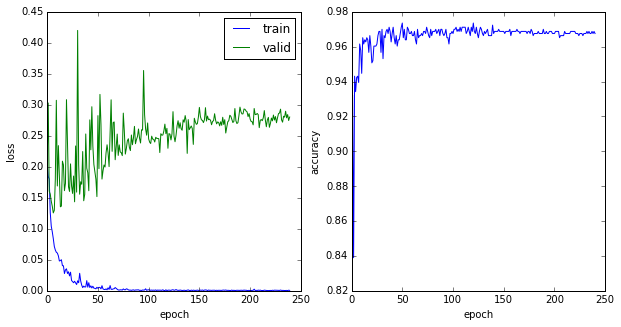

In [25]:
train_loss = [h['train_loss'] for h in net.train_history_]
valid_loss = [h['valid_loss'] for h in net.train_history_]
acc = [h['valid_accuracy'] for h in net.train_history_]

net.train_history_

plt.gcf().set_size_inches(10, 5)
plt.subplot(121)
plt.plot(train_loss[1:], label="train")
plt.plot(valid_loss[1:], label="valid")
# plt.gca().set_yscale('log')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")


plt.subplot(122)
plt.plot(acc)
plt.xlabel("epoch")
plt.ylabel("accuracy")

The training usually took 10-12 hours. To skip this, execute the following command to load the trained model that we used .

In [13]:
net.load_params_from("net0.9934.params")

Loaded parameters to layer 'conv1_1' (shape 64x3x3x3).
Loaded parameters to layer 'conv1_1' (shape 64).
Loaded parameters to layer 'conv1_2' (shape 64x64x3x3).
Loaded parameters to layer 'conv1_2' (shape 64).
Loaded parameters to layer 'conv2_1' (shape 128x64x3x3).
Loaded parameters to layer 'conv2_1' (shape 128).
Loaded parameters to layer 'conv2_2' (shape 128x128x3x3).
Loaded parameters to layer 'conv2_2' (shape 128).
Loaded parameters to layer 'conv3_1' (shape 256x128x3x3).
Loaded parameters to layer 'conv3_1' (shape 256).
Loaded parameters to layer 'conv3_2' (shape 256x256x3x3).
Loaded parameters to layer 'conv3_2' (shape 256).
Loaded parameters to layer 'conv3_3' (shape 256x256x3x3).
Loaded parameters to layer 'conv3_3' (shape 256).
Loaded parameters to layer 'conv4_1' (shape 512x256x3x3).
Loaded parameters to layer 'conv4_1' (shape 512).
Loaded parameters to layer 'conv4_2' (shape 512x512x3x3).
Loaded parameters to layer 'conv4_2' (shape 512).
Loaded parameters to layer 'conv4_3'

## Step 3: Make submission

Load test images

In [14]:
ids = pd.read_csv("SubmissionFormat.csv").id.tolist()
filenames = ["%s.jpg" % id for id in ids]

X_pred = load_bee_images("data/test", filenames)
X_pred = prep_images(X_pred)

Make predictions

In [15]:
pred = net.predict_proba(X_pred)[:, 1]

Write submission file

In [19]:
with open("submission.csv", "w") as f:
    out = "id,genus\n" + "\n".join(["%s,%f" % (i, p) for i, p in zip(ids, pred)])
    f.write(out)